In [ ]:
! pip install jcopdl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for jcopdl: filename=jcopdl-1.1.10-py2.py3-none-any.whl size=17927 sha256=a84f2ff32c9f3b37a5e7f3cc651d8f00ebb804ff6d2ab4b1ae17185f4e68bba4
  Stored in directory: /root/.cache/pip/wheels/cc/11/1d/757ab46ad481f6ce465af143396d5d3420e434b17de253a392
Successfully built jcopdl


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import jcopdl
jcopdl.__version__

'1.1.10'

In [ ]:
! unzip /content/drive/MyDrive/data_malaria.zip

Archive:  /content/drive/MyDrive/data_malaria.zip
replace data_malaria/test/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_168.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Dataset & Dataloader

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [ ]:
bs = 32
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder("/content/data_malaria/train", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("/content/data_malaria/test", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# cek kelas
label2cat = train_set.classes
label2cat

['Parasitized', 'Uninfected']

## Arsitektur & Config

### Cara pakai Pretrained-Model

In [ ]:
from torchvision.models import densenet121

In [ ]:
mnet = densenet121(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

### Freeze Model (Bekuin Model)

In [ ]:
for param in mnet.parameters():
    param.requires_grad = False

In [ ]:
mnet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
mnet.classifier = nn.Sequential(
    nn.Linear(1024, 2, bias=True),
    nn.LogSoftmax(dim=1)
)

In [ ]:
%%writefile model.py

from torch import nn, optim
from torchvision.models import densenet121

class DenseNet121(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = densenet121(pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1024, 2, bias=True),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.mnet(x)

    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

Writing model.py


In [ ]:
config = set_config ({
    "output_size" : len(train_set.classes),
    "batch_size" : bs,
    "crop_size" : crop_size,
    "label2cat": label2cat
})

## Pase 1 : Adaptasi (Learning Rate Standard + Patience Kecil)

In [ ]:
model = DenseNet121(config.output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir="model_malaria_DenseNet121")

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
%%writefile loop.py

from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Writing loop.py


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.3205 | Test_cost  = 0.2408 | Train_score = 0.8740 | Test_score = 0.9133 |


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.2598 | Test_cost  = 0.2240 | Train_score = 0.8980 | Test_score = 0.9122 |
==> EarlyStop patience =  1 | Best test_score: 0.9133


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.2420 | Test_cost  = 0.2259 | Train_score = 0.9084 | Test_score = 0.9213 |


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.2394 | Test_cost  = 0.2058 | Train_score = 0.9110 | Test_score = 0.9213 |
==> EarlyStop patience =  1 | Best test_score: 0.9213


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.2356 | Test_cost  = 0.2230 | Train_score = 0.9105 | Test_score = 0.9122 |
==> EarlyStop patience =  2 | Best test_score: 0.9213
==> Execute Early Stopping at epoch: 5 | Best test_score: 0.9213
==> Best model is saved at model_malaria_DenseNet121


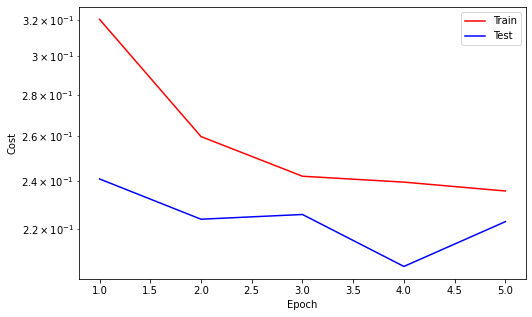

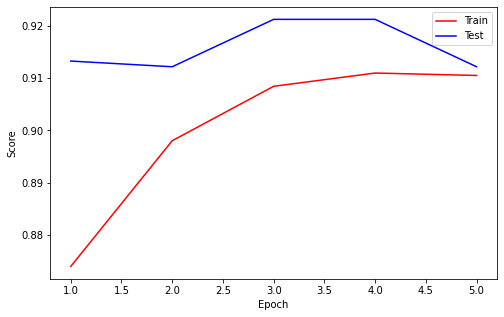

In [ ]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Pase 2 : Fine-Tuning (learning rate dikecilin, patience ditambah)

In [ ]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5

Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.1712 | Test_cost  = 0.1466 | Train_score = 0.9399 | Test_score = 0.9478 |


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa9169a5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.1415 | Test_cost  = 0.1332 | Train_score = 0.9523 | Test_score = 0.9507 |


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.1238 | Test_cost  = 0.1329 | Train_score = 0.9565 | Test_score = 0.9525 |


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.1141 | Test_cost  = 0.1218 | Train_score = 0.9602 | Test_score = 0.9521 |
==> EarlyStop patience =  1 | Best test_score: 0.9525


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.1047 | Test_cost  = 0.1154 | Train_score = 0.9635 | Test_score = 0.9554 |


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.0984 | Test_cost  = 0.1123 | Train_score = 0.9655 | Test_score = 0.9557 |


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa9169a5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa9169a5f0>Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():    
  File "/usr/lib/pytho

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.0915 | Test_cost  = 0.1083 | Train_score = 0.9677 | Test_score = 0.9590 |


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.0835 | Test_cost  = 0.1085 | Train_score = 0.9714 | Test_score = 0.9597 |


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa9169a5f0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa9169a5f0>  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

      File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():
AssertionErrorException ignored in:   File "/usr/lib/python3.7/multi

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.0791 | Test_cost  = 0.1071 | Train_score = 0.9712 | Test_score = 0.9586 |
==> EarlyStop patience =  1 | Best test_score: 0.9597


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.0719 | Test_cost  = 0.1059 | Train_score = 0.9751 | Test_score = 0.9590 |
==> EarlyStop patience =  2 | Best test_score: 0.9597


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.0717 | Test_cost  = 0.1027 | Train_score = 0.9746 | Test_score = 0.9594 |
==> EarlyStop patience =  3 | Best test_score: 0.9597


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.0690 | Test_cost  = 0.1106 | Train_score = 0.9756 | Test_score = 0.9597 |
==> EarlyStop patience =  4 | Best test_score: 0.9597


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa9169a5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():

  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa9169a5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.0638 | Test_cost  = 0.1078 | Train_score = 0.9781 | Test_score = 0.9608 |


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.0616 | Test_cost  = 0.1074 | Train_score = 0.9803 | Test_score = 0.9619 |


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.0567 | Test_cost  = 0.1111 | Train_score = 0.9802 | Test_score = 0.9626 |


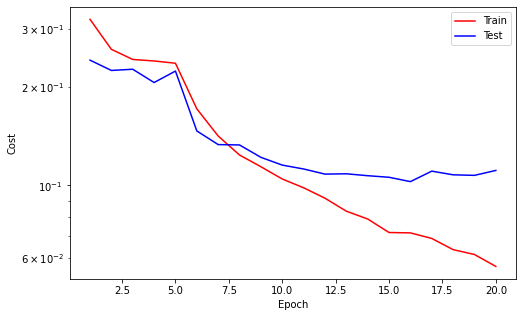

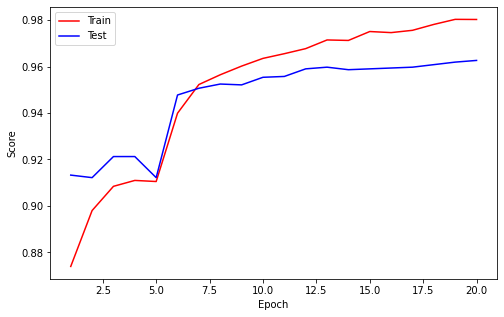

Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.0534 | Test_cost  = 0.1113 | Train_score = 0.9815 | Test_score = 0.9572 |
==> EarlyStop patience =  1 | Best test_score: 0.9626


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.0523 | Test_cost  = 0.1083 | Train_score = 0.9818 | Test_score = 0.9601 |
==> EarlyStop patience =  2 | Best test_score: 0.9626


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa9169a5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa9169a5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.0490 | Test_cost  = 0.1118 | Train_score = 0.9840 | Test_score = 0.9612 |
==> EarlyStop patience =  3 | Best test_score: 0.9626


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa9169a5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa9169a5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.0479 | Test_cost  = 0.1119 | Train_score = 0.9849 | Test_score = 0.9630 |


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.0461 | Test_cost  = 0.1167 | Train_score = 0.9839 | Test_score = 0.9619 |
==> EarlyStop patience =  1 | Best test_score: 0.9630


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa9169a5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa9169a5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.0401 | Test_cost  = 0.1157 | Train_score = 0.9871 | Test_score = 0.9586 |
==> EarlyStop patience =  2 | Best test_score: 0.9630


Exception ignored in: 

Train:   0%|          | 0/603 [00:00<?, ?it/s]

<function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa9169a5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa9169a5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/p

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.0428 | Test_cost  = 0.1187 | Train_score = 0.9865 | Test_score = 0.9604 |
==> EarlyStop patience =  3 | Best test_score: 0.9630


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.0388 | Test_cost  = 0.1205 | Train_score = 0.9874 | Test_score = 0.9623 |
==> EarlyStop patience =  4 | Best test_score: 0.9630


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.0365 | Test_cost  = 0.1190 | Train_score = 0.9879 | Test_score = 0.9644 |


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa9169a5f0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa9169a5f0>Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__

    Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()    
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa9169a5f0>self._shutdown_workers()  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

    
if w.is_alive():  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Traceback (most recent call last):

  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
      File "/usr

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.0332 | Test_cost  = 0.1274 | Train_score = 0.9897 | Test_score = 0.9634 |
==> EarlyStop patience =  1 | Best test_score: 0.9644


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.0309 | Test_cost  = 0.1342 | Train_score = 0.9901 | Test_score = 0.9637 |
==> EarlyStop patience =  2 | Best test_score: 0.9644


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.0351 | Test_cost  = 0.1249 | Train_score = 0.9883 | Test_score = 0.9630 |
==> EarlyStop patience =  3 | Best test_score: 0.9644


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.0300 | Test_cost  = 0.1240 | Train_score = 0.9906 | Test_score = 0.9630 |
==> EarlyStop patience =  4 | Best test_score: 0.9644


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Test:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.0274 | Test_cost  = 0.1341 | Train_score = 0.9916 | Test_score = 0.9626 |
==> EarlyStop patience =  5 | Best test_score: 0.9644
==> Execute Early Stopping at epoch: 34 | Best test_score: 0.9644
==> Best model is saved at model_malaria_DenseNet121


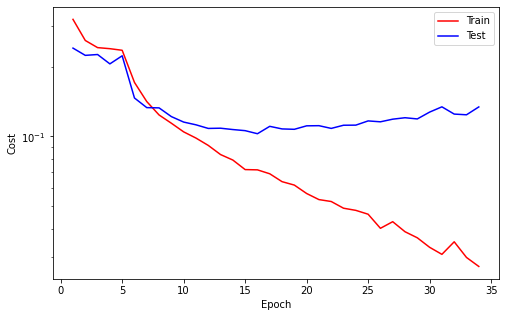

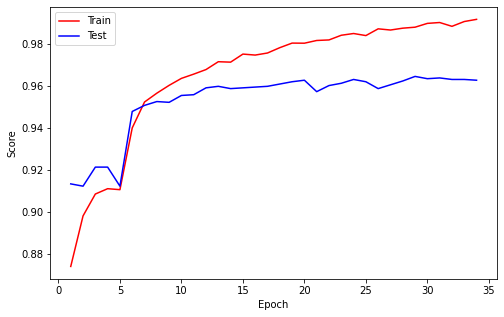

In [ ]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Prediksi

In [ ]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [ ]:
with torch.no_grad():
        model.eval()
        output = model(feature)
        preds = output.argmax(1)
[label2cat [pred] for pred in preds]

['Uninfected',
 'Parasitized',
 'Parasitized',
 'Uninfected',
 'Parasitized',
 'Parasitized',
 'Parasitized',
 'Uninfected',
 'Uninfected',
 'Parasitized',
 'Parasitized',
 'Uninfected',
 'Uninfected',
 'Parasitized',
 'Uninfected',
 'Parasitized',
 'Uninfected',
 'Parasitized',
 'Uninfected',
 'Parasitized',
 'Parasitized',
 'Uninfected',
 'Uninfected',
 'Parasitized',
 'Uninfected',
 'Parasitized',
 'Uninfected',
 'Parasitized',
 'Uninfected',
 'Parasitized',
 'Parasitized',
 'Uninfected']

## Sanity Check (Visualisasi)

In [ ]:
%%writefile utils.py
def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

Writing utils.py


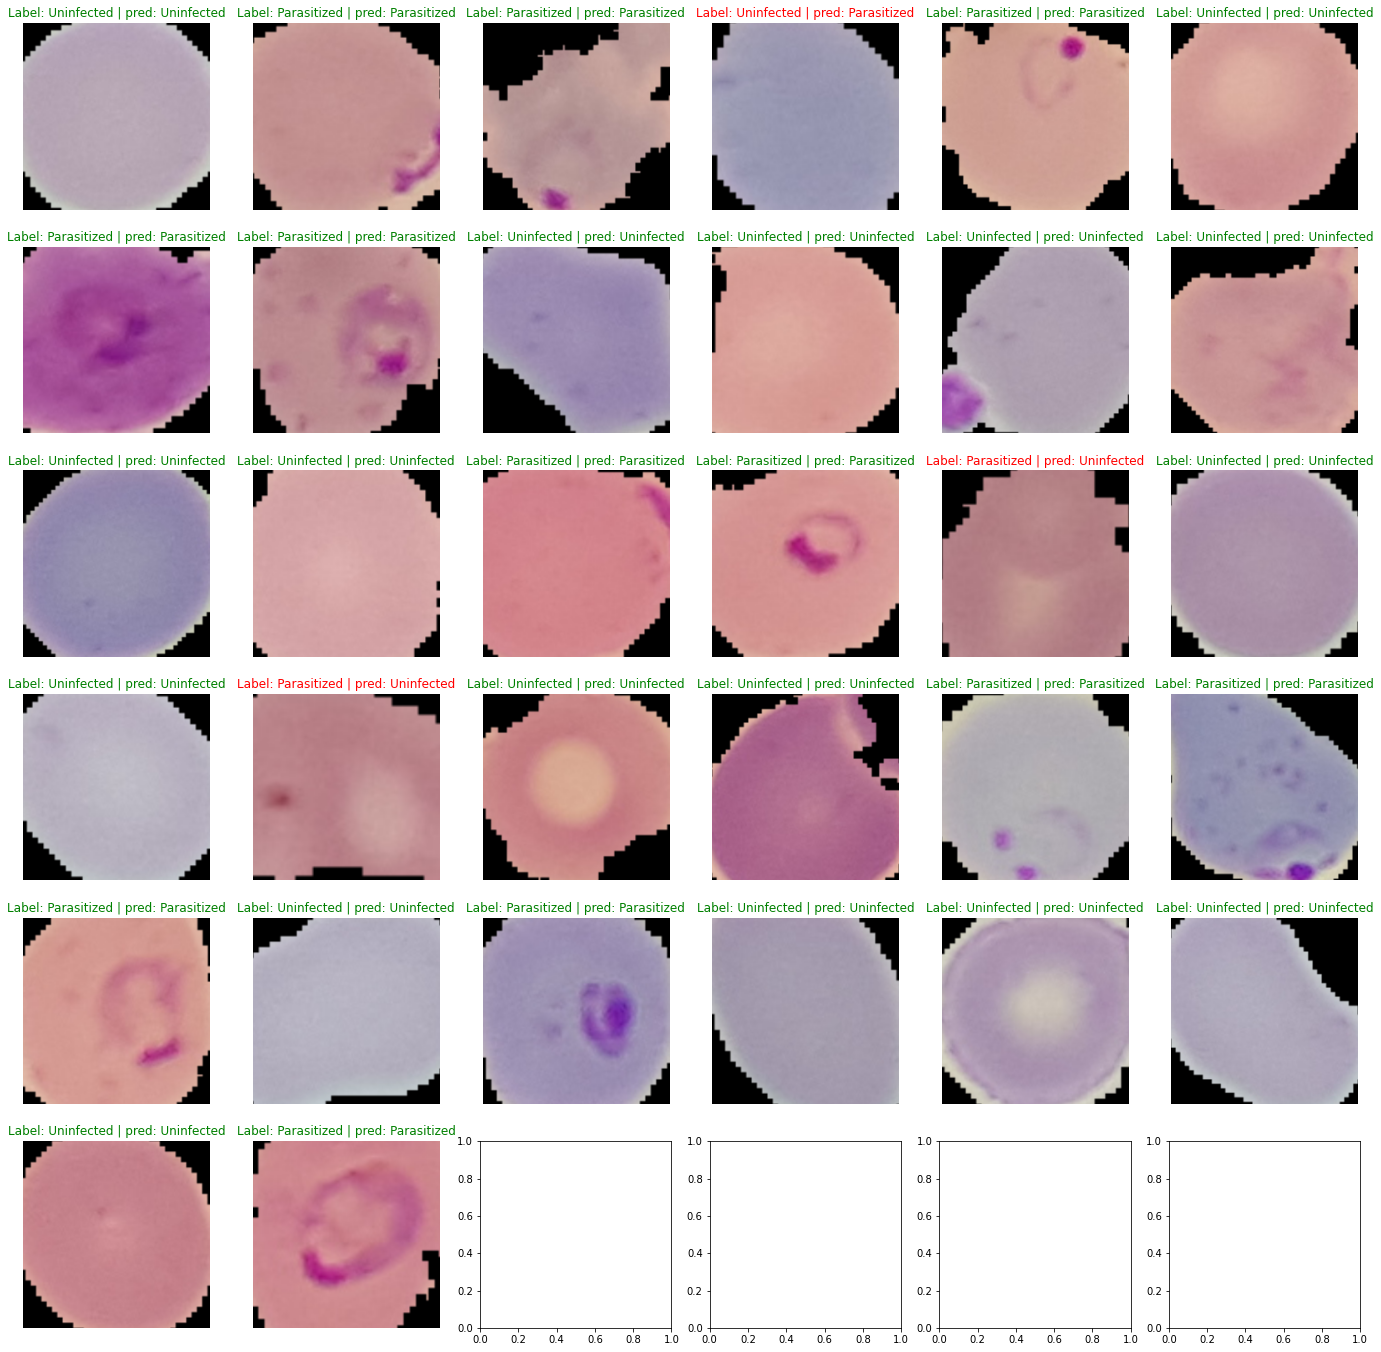

In [ ]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)

fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    img = inverse_norm(img) # inverse normalisasi agar warna kembali normal
    img = img.permute(1, 2, 0).cpu() # ubah CHW jadi HWC

    ax.imshow(img)
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} | pred: {pred}", fontdict=font);
    ax.axis("off");

### Save Model

In [ ]:
! zip -r model_malaria_DenseNet121.zip /content/model_malaria_DenseNet121

  adding: content/model_malaria_DenseNet121/ (stored 0%)
  adding: content/model_malaria_DenseNet121/configs.pth (deflated 49%)
  adding: content/model_malaria_DenseNet121/logs.pth (deflated 24%)
  adding: content/model_malaria_DenseNet121/weights_best.pth (deflated 7%)


In [ ]:
! zip -r src_malaria.zip /content/model_malaria_efficienceNetB0/src

  adding: content/model_malaria_efficienceNetB0/src/ (stored 0%)
  adding: content/model_malaria_efficienceNetB0/src/model.py (deflated 58%)
  adding: content/model_malaria_efficienceNetB0/src/utils.py (deflated 51%)
  adding: content/model_malaria_efficienceNetB0/src/loop.py (deflated 58%)


In [ ]:
! pip install jcopdl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for jcopdl: filename=jcopdl-1.1.10-py2.py3-none-any.whl size=17928 sha256=6b9b8d6d8f06c0313ab059ff2b10452bc092def5bd8d777f5ed3cc8ffb202bbd
  Stored in directory: /root/.cache/pip/wheels/cc/11/1d/757ab46ad481f6ce465af143396d5d3420e434b17de253a392
Successfully built jcopdl


## Prediksi

In [ ]:
! pip install jcopdl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for jcopdl: filename=jcopdl-1.1.10-py2.py3-none-any.whl size=17927 sha256=4603adfae66cd3c5172e7c16e7220e4c80862fcc3b8a582aa3f41ad1a22328fc
  Stored in directory: /root/.cache/pip/wheels/cc/11/1d/757ab46ad481f6ce465af143396d5d3420e434b17de253a392
Successfully built jcopdl


In [ ]:
! unzip /content/model_malaria_DenseNet121.zip

Archive:  /content/model_malaria_DenseNet121.zip
   creating: content/model_malaria_DenseNet121/
  inflating: content/model_malaria_DenseNet121/configs.pth  
  inflating: content/model_malaria_DenseNet121/logs.pth  
  inflating: content/model_malaria_DenseNet121/weights_best.pth  


In [ ]:
! unzip /content/drive/MyDrive/data_malaria.zip

Streaming output truncated to the last 5000 lines.
  inflating: data_malaria/val/Parasitized/C132P93ThinF_IMG_20151004_151701_cell_173.png  
  inflating: data_malaria/val/Parasitized/C132P93ThinF_IMG_20151004_151701_cell_175.png  
  inflating: data_malaria/val/Parasitized/C132P93ThinF_IMG_20151004_151701_cell_177.png  
  inflating: data_malaria/val/Parasitized/C132P93ThinF_IMG_20151004_151701_cell_182.png  
  inflating: data_malaria/val/Parasitized/C132P93ThinF_IMG_20151004_151701_cell_183.png  
  inflating: data_malaria/val/Parasitized/C132P93ThinF_IMG_20151004_151701_cell_184.png  
  inflating: data_malaria/val/Parasitized/C132P93ThinF_IMG_20151004_151733_cell_145.png  
  inflating: data_malaria/val/Parasitized/C132P93ThinF_IMG_20151004_151733_cell_149.png  
  inflating: data_malaria/val/Parasitized/C132P93ThinF_IMG_20151004_151733_cell_155.png  
  inflating: data_malaria/val/Parasitized/C132P93ThinF_IMG_20151004_151733_cell_161.png  
  inflating: data_malaria/val/Parasitized/C132P93

In [ ]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
from torchvision import transforms
from torchvision.models import densenet121
from PIL import Image
from utils import inverse_norm
from model import DenseNet121

In [ ]:
class MalariaClassifier:
    def __init__(self, weight_path, config_path):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        config = torch.load(config_path)
        self.label2cat = config.label2cat

        weight = torch.load(weight_path, map_location="cpu")
        model = DenseNet121(config.output_size)
        model.load_state_dict(weight)
        self.model = model.to(device)

    def predict(self, fname):
        image = Image.open(fname)
        feature = self.transform(image).to(self.device)
        feature = feature.unsqueeze(0)

        with torch.no_grad():
            self.model.eval()
            output = self.model(feature)
            preds = output.argmax(1)
        return self.label2cat[preds]

In [ ]:
clf = MalariaClassifier("/content/content/model_malaria_DenseNet121/weights_best.pth", "/content/content/model_malaria_DenseNet121/configs.pth")

In [ ]:
clf.predict("/content/data_malaria/val/Parasitized/C100P61ThinF_IMG_20150918_145042_cell_162.png")

'Parasitized'

In [ ]:
clf.predict("/content/data_malaria/val/Uninfected/C100P61ThinF_IMG_20150918_144823_cell_127.png")

'Uninfected'

In [ ]:
clf.predict("/content/data_malaria/val/Uninfected/C100P61ThinF_IMG_20150918_145609_cell_99.png")

'Uninfected'

In [ ]:
clf.predict("/content/data_malaria/val/Parasitized/C101P62ThinF_IMG_20150918_151149_cell_69.png")

'Parasitized'

In [ ]:
clf.predict("/content/data_malaria/val/Parasitized/C101P62ThinF_IMG_20150918_151006_cell_76.png")

'Parasitized'

In [ ]:
! zip -r malaria_DenseNet121.zip /content/content/model_malaria_DenseNet121

  adding: content/content/model_malaria_DenseNet121/ (stored 0%)
  adding: content/content/model_malaria_DenseNet121/logs.pth (deflated 24%)
  adding: content/content/model_malaria_DenseNet121/.ipynb_checkpoints/ (stored 0%)
  adding: content/content/model_malaria_DenseNet121/src/ (stored 0%)
  adding: content/content/model_malaria_DenseNet121/src/loop.py (deflated 58%)
  adding: content/content/model_malaria_DenseNet121/src/model.py (deflated 58%)
  adding: content/content/model_malaria_DenseNet121/src/utils.py (deflated 51%)
  adding: content/content/model_malaria_DenseNet121/weights_best.pth (deflated 7%)
  adding: content/content/model_malaria_DenseNet121/configs.pth (deflated 49%)
